# Natural Language Processing Project (NADI 2023 Dialect Identification)
## Ahmed Yasser - Syed Fawaz - Ramy Gamal

### Given this fine tuned version of Marbert, we will now augment it with a lexicon stage.
### First, we will normalize our training dataset and take 1000 tweets per dialect for lexicon extraction. We remove diacritics and normalize unusual characters.

In [1]:
!pip install pandas
!pip install numpy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\yasse\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\yasse\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import re
import pandas as pd
import numpy as np

# 1) Load the full NADI training set
df = pd.read_csv('NADI2023_Subtask1_TRAIN.tsv', sep='\t')

# 2) Define the normalization function (minimal Marbert-style cleaning)
arabic_diacritics = re.compile(r"""
    ّ    | # Tashdid
    َ    | # Fatha
    ً    | # Fathatan
    ُ    | # Damma
    ٌ    | # Dammatan
    ِ    | # Kasra
    ٍ    | # Kasratan
    ْ    | # Sukun
    ـ      # Tatweel
""", re.VERBOSE)
url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')
elongation_pattern = re.compile(r'(.)\1{2,}')  # more than 2 repeats
emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F700-\U0001F77F"  # alchemical symbols
                          u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                          u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                          u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                          u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                          u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                          u"\U00002702-\U000027B0"  # Dingbats
                          "]+", flags=re.UNICODE)

# Expanded normalization map
norm_map = {
    'إ': 'ا', 'أ': 'ا', 'آ': 'ا',
    'ى': 'ي', 'ئ': 'ي', 'ؤ': 'و',
    'ة': 'ه',
    # Additional normalizations
    'گ': 'ك', 'ڤ': 'ف', 'پ': 'ب',
    'چ': 'ج', 'ژ': 'ز', 'ڨ': 'ق',
    'ڭ': 'ك', 'ڜ': 'ش'
}
placeholder_re = re.compile(r'\b(?:USER|NUM|URL)\b')

def normalize(text):
    if pd.isna(text) or text == '':
        return ''
        
    text = re.sub(arabic_diacritics, '', text)      # remove diacritics
    for src, tgt in norm_map.items():
        text = text.replace(src, tgt)               # normalize characters
    text = url_pattern.sub('', text)                # remove URLs
    text = mention_pattern.sub('', text)            # remove mentions
    text = hashtag_pattern.sub('', text)            # remove hashtags
    text = emoji_pattern.sub('', text)              # remove emojis
    text = elongation_pattern.sub(r'\1\1', text)    # reduce elongations
    text = re.sub(r'\s+', ' ', text).strip()        # collapse whitespace
    text = placeholder_re.sub('', text)             # drop USER/NUM/URL
    return text

# 3) Apply normalization across all tweets
df['clean_text'] = df['#2_content'].fillna('').apply(normalize)

# Filter out empty strings after normalization
df = df[df['clean_text'] != '']

# 4) Sample up to 1000 tweets per dialect (safely handling cases with fewer than 1000)
SAMPLES_PER_DIALECT = 2000
sampled_dfs = []

for dialect, group in df.groupby('#3_label'):
    if len(group) >= SAMPLES_PER_DIALECT:
        sampled_dfs.append(group.sample(n=SAMPLES_PER_DIALECT, random_state=42))
    else:
        print(f"Warning: Dialect '{dialect}' has only {len(group)} examples (<{SAMPLES_PER_DIALECT})")
        sampled_dfs.append(group)  # Use all available examples for this dialect

sampled = pd.concat(sampled_dfs).reset_index(drop=True)

# 5) Display the counts per dialect
counts = sampled['#3_label'].value_counts().sort_index().rename('Sampled_Count').reset_index()
counts.columns = ['Dialect', 'Sampled_Count']

print(f"Total tweets in balanced dataset: {len(sampled)}")
counts.head(len(counts))

Total tweets in balanced dataset: 18000


,Dialect,Sampled_Count
0,Algeria,1000
1,Bahrain,1000
2,Egypt,1000
3,Iraq,1000
4,Jordan,1000
5,Kuwait,1000
6,Lebanon,1000
7,Libya,1000
8,Morocco,1000
9,Oman,1000


### Now that we have the sample of tweets for evey dialect, we will check to see the most frequently repeated words across the entire data. Those words are considered stop words that are used in multiple dialects, which means that they are less likely to benefit our classification.

In [3]:
import pandas as pd
from collections import Counter

# 1) Build a global token frequency counter over all sampled, normalized tweets
global_cnt = Counter()
for text in sampled['clean_text']:
    # simple whitespace tokenization
    tokens = text.split()
    global_cnt.update(tokens)

# 2) Compute total token count
total_tokens = sum(global_cnt.values())

# 3) Identify global stop-tokens (appear in >1% of all tokens)
global_stops = {tok for tok, cnt in global_cnt.items() if cnt / total_tokens > 0.01}

freq_df = (
    pd.DataFrame(global_cnt.items(), columns=["token", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)
freq_df.head(20)            # display top 20



,token,count
0,من,3949
1,في,3775
2,و,3149
3,ما,2900
4,علي,1891
5,الله,1644
6,يا,1571
7,انا,1292
8,لا,1230
9,اللي,1211


### We notice that in the beginning, we have very common stop words and as we move towards the bottom we start finding stop words that are common in only some specific languages. To avoid missing important information, we will rely on TF IDF to extract non stop word lexicon.

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 1) Compute global word frequencies if not already defined
def compute_global_counts(texts):
    global_counter = Counter()
    for text in texts:
        words = text.split()
        global_counter.update(words)
    return global_counter

# Calculate global counts if not already done
global_cnt = compute_global_counts(sampled['clean_text'])

# Get top N global stop words (adjust N as needed)
N_STOPS = 25  # Increased from 17 to capture more common Arabic function words
top_stops = [tok for tok, _ in global_cnt.most_common(N_STOPS)]

# Filter out very short words (likely not dialect-specific)
MIN_WORD_LENGTH = 2
filtered_stops = [word for word in top_stops if len(word) >= MIN_WORD_LENGTH]

# 2) Rebuild per-dialect pseudo-documents
dialect_docs = sampled.groupby('#3_label')['clean_text'].apply(lambda texts: " ".join(texts)).to_dict()
docs = list(dialect_docs.values())
dialects = list(dialect_docs.keys())

# 3) Initialize TF-IDF vectorizer with adjusted parameters
vectorizer = TfidfVectorizer(
    tokenizer=lambda text: [w for w in text.split() if len(w) >= MIN_WORD_LENGTH],
    stop_words=filtered_stops,
    max_features=5000,           # Limit to most relevant features
    min_df=5,                    # Ignore very rare terms (noise)
    max_df=0.8,                  # Ignore terms that appear in >80% of documents
    smooth_idf=False,            # No smoothing for steeper IDF curve
    sublinear_tf=True,           # Dampen effect of high TF with log scaling
    norm=None,                   # No normalization to preserve IDF impact
    use_idf=True,                # Ensure IDF weighting is on
    ngram_range=(1, 2)           # Include bigrams which might be dialect-specific
)


# 4) Fit TF-IDF on the dialect pseudo-documents
X = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

# 5) Extract top tokens by TF-IDF score for each dialect …


# 5) Extract top tokens by TF-IDF score for each dialect
TOP_K = 50  # Number of top tokens to extract per dialect
dialect_lexicons = {}

for i, dialect in enumerate(dialects):
    # Get scores for this dialect
    row = X[i].toarray().ravel()
    
    # Filter out zero scores and sort
    nonzero_indices = np.nonzero(row)[0]
    sorted_indices = nonzero_indices[np.argsort(-row[nonzero_indices])]
    
    # Get top K tokens
    top_indices = sorted_indices[:TOP_K]
    dialect_lexicons[dialect] = [feature_names[j] for j in top_indices]

# 6) Prepare a DataFrame to show sample tokens
sample_lexicons = []
for dialect in dialects:
    # Show first 25 tokens for each dialect
    tokens = dialect_lexicons[dialect][:25]
    sample_lexicons.append({
        'Dialect': dialect, 
        'Top_Tokens': ", ".join(tokens)
    })

sample_df = pd.DataFrame(sample_lexicons)
print(f"Extracted {TOP_K} dialect-specific tokens for each of the {len(dialects)} dialects")
print(sample_df)

C:\Users\yasse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Extracted 50 dialect-specific tokens for each of the 18 dialects
         Dialect                                         Top_Tokens
0        Algeria  كي, راني, كاين, راك, باش, خخ, بلادنا, هذاك, عل...
1        Bahrain  عقب, احبك, لين, ايي, واني, مادري, ذي, اسوي, اب...
2          Egypt  كده, لسه, اوي, ربنا, دا, معايا, اي حاجه, كتير,...
3           Iraq  جان, كلش, واني, بيه, شلون, اريد, كا, شنو, هاي,...
4         Jordan  هيك, حدا, لسا, شو, هون, هاد, رح, بعرف, بدنا, ب...
5         Kuwait  يبارك فيك, مادري, الحين, احبك, شلون, شنو, عسي,...
6        Lebanon  متل, هيك, حدا, لبنان, يلي, بدك, شو, انو, عم, ب...
7          Libya  مافيش, واجد, تبي, بيه, تو, معاش, يبي, هما, ديم...
8        Morocco  هاد, علاش, كاين, باش, ملي, اش, ليك, de, بغيت, ...
9           Oman  تو, عمان, تراه, الحين, لين, ذا, مال, شركات, ار...
10     Palestine  هيك, فلسطين, الاحتلال, حدا, هاد, شو, انو, عمي,...
11         Qatar  مب, القطري, عقب, المجد, كفو, الحين, وايد, لين,...
12  Saudi_Arabia  النصر, ذا, الهلال, الحين, تبي, كف

### Those lexicons show promising results. Lexicons for some languages include cultural references, geopolitical entities, and even common phrases as 'اي حاجه'
### Now let's dive deeply to see all 50 lexicons for a sample of the dialects

In [5]:
# Select three diverse dialects to examine
sample_dialects = ['Egypt', 'Qatar', 'Morocco']

# Create a prettier format for displaying the full token lists
print("\n" + "="*80)
print("FULL DIALECT LEXICONS (50 tokens each)")
print("="*80)

for dialect in sample_dialects:
    if dialect in dialect_lexicons:
        # Get the full 50-token lexicon
        tokens = dialect_lexicons[dialect]
        
        # Print header with dialect name
        print(f"\n{dialect.upper()} DIALECT - FULL 50 TOKENS:")
        print("-" * 60)
        
        # Print tokens with their index numbers in groups of 5 for readability
        for i in range(0, len(tokens), 5):
            group = tokens[i:i+5]
            indices = [f"{j+1}" for j in range(i, i+len(group))]
            formatted_group = [f"{idx}. {token}" for idx, token in zip(indices, group)]
            print("  ".join(formatted_group))
            
        # Add visual separation between dialects
        print("-" * 60)

print("\n" + "="*80)


FULL DIALECT LEXICONS (50 tokens each)

EGYPT DIALECT - FULL 50 TOKENS:
------------------------------------------------------------
1. كده  2. لسه  3. اوي  4. ربنا  5. دا
6. معايا  7. اي حاجه  8. كتير  9. الاهلي  10. كفايه
11. خالص  12. حاجه  13. امبارح  14. ايه  15. بقيت
16. الراجل  17. حاجات  18. تاني  19. الاخر  20. ومش
21. كويس  22. السيسي  23. بحس  24. اكتر  25. حضرتك
26. بيه  27. هما  28. عليا  29. مصر  30. بقي
31. محتاج  32. علشان  33. فين  34. طب  35. زي
36. بيها  37. محتاجه  38. مرسي  39. الكليه  40. عليكي
41. كمان  42. تيجي  43. بدري  44. بيقولوا  45. امتي
46. اه  47. مهما  48. مين  49. يعمل  50. اعمل
------------------------------------------------------------

QATAR DIALECT - FULL 50 TOKENS:
------------------------------------------------------------
1. مب  2. القطري  3. عقب  4. المجد  5. كفو
6. الحين  7. وايد  8. لين  9. قطر  10. شلون
11. مادري  12. العز  13. محمد بن  14. ترامب  15. حمد
16. الامير  17. الردي  18. الحج  19. لقطر  20. خل
21. الطيب  22. جعل  23. ابي  24. م

### One potential problem we notice here is that some dialects have many dialect specific words such as the Egyptian and Maghrebi dialects. However, some gulf dialects do not have sufficient 50 specific words, at least in our dataset. Using 50 words for every dialect would just add noise and data-based bias which we would want to avoid.

### Instead of using a fixed number of tokens across all dialects, an adaptive approach could select different numbers of tokens for each dialect based on their distinctiveness. It stops taking lexicon from a dialect when there is a sudden drop in TF IDF

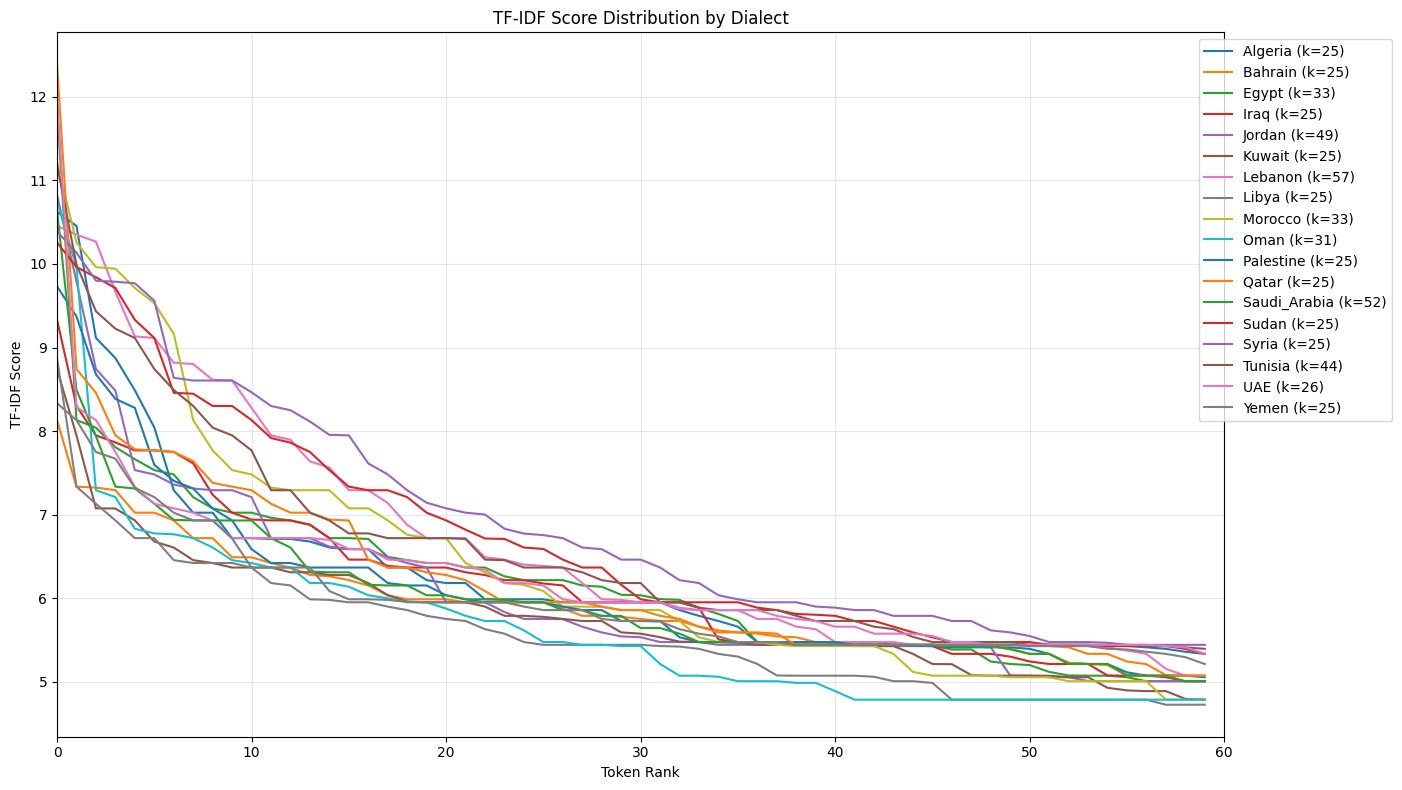


Dynamic Token Count per Dialect:
         Dialect  Token_Count
0        Algeria           25
14         Syria           25
13         Sudan           25
11         Qatar           25
10     Palestine           25
7          Libya           25
17         Yemen           25
5         Kuwait           25
3           Iraq           25
1        Bahrain           25
16           UAE           26
9           Oman           31
2          Egypt           33
8        Morocco           33
15       Tunisia           44
4         Jordan           49
12  Saudi_Arabia           52
6        Lebanon           57

Extracted dialect-specific tokens with dynamic thresholds
Range: 25 to 57 tokens per dialect

SAMPLE DIALECT LEXICONS (with dynamic token counts):

ALGERIA DIALECT - 25 TOKENS:
------------------------------------------------------------
1. كي 2. راني 3. كاين 4. راك 5. باش 
   6. خخ 7. بلادنا 8. هذاك 9. علاش 10. حبايبي 
   11. نحبك 12. ليك 13. هاد 14. بلادي 15. قالك 
   16. مي 17. حنا 18. الب

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 5) Function for adaptive threshold based on score distribution
def find_optimal_tokens(scores, min_tokens=20, max_tokens=75, sig_drop_threshold=0.2):
    """
    Find optimal number of tokens based on TF-IDF score distribution:
    - Looks for a significant drop in TF-IDF scores
    - Ensures a minimum and maximum number of tokens
    - Returns a conservative estimate to maintain quality
    
    Parameters:
    - scores: Array of sorted (descending) TF-IDF scores
    - min_tokens: Minimum tokens to return regardless of scores
    - max_tokens: Maximum tokens to consider
    - sig_drop_threshold: What constitutes a significant drop (percentage)
    
    Returns:
    - optimal_k: Recommended number of tokens
    """
    # Limit to max_tokens for analysis
    scores = scores[:max_tokens]
    
    # Calculate percentage drops between consecutive scores
    drops = np.diff(scores) / np.maximum(scores[:-1], 1e-10)  # Avoid division by zero
    
    # Find significant drops (where score drops by more than threshold)
    significant_drops = np.where(drops > sig_drop_threshold)[0]
    
    # Find first significant drop after minimum tokens
    valid_drops = [idx for idx in significant_drops if idx >= min_tokens-1]
    
    if valid_drops:
        # Return position of first significant drop after minimum
        return valid_drops[0] + 1  # +1 because drop is between positions
    else:
        # Look at absolute scores to determine cutoff
        # Find where scores fall below 50% of the maximum score
        relative_threshold = 0.5 * scores[0]
        below_threshold = np.where(scores < relative_threshold)[0]
        
        if below_threshold.size > 0 and below_threshold[0] >= min_tokens:
            return below_threshold[0]
        else:
            # If no clear cutoff is found, use default min_tokens
            return min_tokens

# 6) Extract dynamic number of tokens for each dialect
dialect_lexicons = {}
token_counts = {}
all_scores = []

for i, dialect in enumerate(dialects):
    # Get scores for this dialect
    row = X[i].toarray().ravel()
    
    # Filter out zero scores and sort
    nonzero_indices = np.nonzero(row)[0]
    sorted_indices = nonzero_indices[np.argsort(-row[nonzero_indices])]
    sorted_scores = row[sorted_indices]
    
    # Find optimal token count for this dialect
    k = find_optimal_tokens(sorted_scores, min_tokens=25, max_tokens=60)
    token_counts[dialect] = k
    
    # Store scores for visualization
    all_scores.append(sorted_scores[:60])  # Store up to 60 for plotting
    
    # Get top k tokens
    top_indices = sorted_indices[:k]
    dialect_lexicons[dialect] = [feature_names[j] for j in top_indices]

# 7) Visualize score distributions to verify approach
plt.figure(figsize=(14, 8))
for i, (dialect, scores) in enumerate(zip(dialects, all_scores)):
    plt.plot(scores, label=f"{dialect} (k={token_counts[dialect]})")

plt.xlabel('Token Rank')
plt.ylabel('TF-IDF Score')
plt.title('TF-IDF Score Distribution by Dialect')
plt.grid(True, alpha=0.3)
plt.xlim(0, 60)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.savefig('dialect_tfidf_scores.png')
plt.show()

# 8) Display token counts for each dialect
token_count_df = pd.DataFrame({
    'Dialect': list(token_counts.keys()),
    'Token_Count': list(token_counts.values())
})
print("\nDynamic Token Count per Dialect:")
print(token_count_df.sort_values('Token_Count'))

# 9) Prepare sample output to show tokens
sample_lexicons = []
for dialect in dialects:
    # Format tokens with indices for readability
    formatted_tokens = []
    for i, token in enumerate(dialect_lexicons[dialect]):
        if i % 5 == 0 and i > 0:
            formatted_tokens.append("\n  ")  # Line break every 5 tokens
        formatted_tokens.append(f"{i+1}. {token}")
    
    sample_lexicons.append({
        'Dialect': dialect,
        'Token_Count': token_counts[dialect],
        'Tokens': " ".join(formatted_tokens)
    })

sample_df = pd.DataFrame(sample_lexicons)

# 10) Save lexicons to file for later use
lexicon_df = pd.DataFrame([
    {'dialect': d, 'token_idx': i, 'token': t} 
    for d, tokens in dialect_lexicons.items() 
    for i, t in enumerate(tokens)
])
lexicon_df.to_csv('dialect_lexicons.csv', index=False)

print(f"\nExtracted dialect-specific tokens with dynamic thresholds")
print(f"Range: {min(token_counts.values())} to {max(token_counts.values())} tokens per dialect")

# Display sample of lexicons (first 3 dialects)
print("\nSAMPLE DIALECT LEXICONS (with dynamic token counts):")
print("="*80)
for _, row in sample_df.iloc[:3].iterrows():
    print(f"\n{row['Dialect'].upper()} DIALECT - {row['Token_Count']} TOKENS:")
    print("-" * 60)
    print(row['Tokens'])
    print("-" * 60)

In [7]:
# build the same analyzer you used for TF-IDF
analyzer = vectorizer.build_analyzer()

# for each tweet, check if any token is in its dialect’s lexicon
sampled['has_lex_token'] = sampled.apply(
    lambda row: any(tok in dialect_lexicons[row['#3_label']]
                    for tok in analyzer(row['clean_text'])),
    axis=1
)

# overall fraction of tweets where the true dialect’s lexicon fired
coverage = sampled['has_lex_token'].mean()
print(f"Coverage of true-dialect lexicon: {coverage:.3f}")

# (optional) see per-dialect coverage
print(sampled.groupby('#3_label')['has_lex_token']
            .mean()
            .sort_values(ascending=False))


Coverage of true-dialect lexicon: 0.373
#3_label
Lebanon         0.625
Syria           0.547
Jordan          0.477
Egypt           0.466
Sudan           0.452
Morocco         0.430
Saudi_Arabia    0.428
Tunisia         0.408
Qatar           0.393
UAE             0.336
Oman            0.323
Iraq            0.314
Palestine       0.300
Yemen           0.281
Algeria         0.267
Bahrain         0.242
Kuwait          0.235
Libya           0.198
Name: has_lex_token, dtype: float64


### This metric shows us what percentage of labelled tweets have words that are in the lexicon set for that dialect.

### We used a complex approach to fix the lexicon problem we mentioned. We set a minimum and maximum lexicon count for every dialect and we set a threshold for TF_DF.

### Seeing that some dialects such as Algerian and Egyptian have less lexicon than others can be interpreted as follows:

Having a richer, more diverse vocabulary actually works against you if you’re filtering lexicon entries by absolute TF–IDF score or minimum document frequency—most of those unique words don’t show up enough times or aren’t discriminative enough, so they don’t make it into the lexicon.

In [8]:
# --- Dynamic TF-IDF lexicon extraction (mean + k·σ per dialect) ---
k = 3.20   # multiplier for σ; adjust to be more or less selective

token_counts = {}

for idx, dialect in enumerate(dialects):
    # get TF-IDF row for this dialect pseudo-document
    scores = X[idx].toarray().ravel()
    
    # compute dynamic threshold
    mu, sigma = scores.mean(), scores.std()
    threshold = mu + k * sigma
    
    # select features above threshold
    selected_idx = np.where(scores > threshold)[0]
    tokens = feature_names[selected_idx]
    
    # store in your existing lexicon dict
    dialect_lexicons[dialect] = tokens.tolist()
    token_counts[dialect] = len(tokens)
    
    print(f"Dialect '{dialect}': {token_counts[dialect]} tokens (thr={threshold:.4f})")

# OPTIONALLY: save to CSV for inspection
lexicon_df = pd.DataFrame({
    'Dialect': dialects,
    'Token_Count': [token_counts[d] for d in dialects],
    'Tokens': [dialect_lexicons[d] for d in dialects]
})
lexicon_df.to_csv('dialect_lexicons_dynamic.csv', index=False)


Dialect 'Algeria': 34 tokens (thr=5.7437)
Dialect 'Bahrain': 53 tokens (thr=5.3987)
Dialect 'Egypt': 36 tokens (thr=5.6003)
Dialect 'Iraq': 34 tokens (thr=5.5452)
Dialect 'Jordan': 27 tokens (thr=5.7241)
Dialect 'Kuwait': 35 tokens (thr=5.4718)
Dialect 'Lebanon': 36 tokens (thr=5.8125)
Dialect 'Libya': 25 tokens (thr=5.4483)
Dialect 'Morocco': 44 tokens (thr=5.3125)
Dialect 'Oman': 24 tokens (thr=5.6388)
Dialect 'Palestine': 32 tokens (thr=5.5817)
Dialect 'Qatar': 22 tokens (thr=6.1135)
Dialect 'Saudi_Arabia': 21 tokens (thr=6.0200)
Dialect 'Sudan': 36 tokens (thr=5.9215)
Dialect 'Syria': 34 tokens (thr=6.0879)
Dialect 'Tunisia': 38 tokens (thr=5.8344)
Dialect 'UAE': 32 tokens (thr=5.9360)
Dialect 'Yemen': 10 tokens (thr=6.4700)


### This method sets each dialect’s lexicon threshold at its own mean TF-IDF plus k × σ, so you automatically keep more tokens for dialects with strong, concentrated lexical signals and fewer for those with flatter distributions. By adapting to each dialect’s TF-IDF distribution, it avoids arbitrarily penalizing richer vocabularies or inflating noisier ones, unlike fixed‐size or global‐threshold approaches.


In [9]:
# --- Print lexicons for 5 dialects ---
for dialect in dialects[:5]:
    tokens = dialect_lexicons[dialect]
    print(f"Dialect '{dialect}' ({len(tokens)} tokens):")
    print(tokens)
    print("-" * 40)


Dialect 'Algeria' (34 tokens):
['البارح', 'باش', 'بلادنا', 'بلادي', 'بلاك', 'بليز', 'بيها', 'تخرج', 'تولي', 'حابين', 'حبايبي', 'حنا', 'خخ', 'دينا', 'راك', 'راني', 'روحو', 'عباس', 'علاش', 'قالك', 'كاين', 'كي', 'لباس', 'ليك', 'مشاهده', 'مي', 'نحبك', 'نهار', 'هاد', 'هاذ', 'هاذي', 'هاك', 'هذاك', 'يدير']
----------------------------------------
Dialect 'Bahrain' (53 tokens):
['xd', 'ابي', 'ابيك', 'احبك', 'احبه', 'احس', 'اخاف', 'اسوي', 'الحين', 'الدوام', 'الشوق', 'الطالب', 'الهوي', 'الوصل', 'انزين', 'اوكي', 'ايي', 'بك', 'تبي', 'تدري', 'تعال', 'توني', 'حلمي', 'خاطري', 'دنيتي', 'ذاك', 'ذي', 'سالفه', 'شعور', 'شلون', 'شوفتك', 'صوتك', 'طلبه', 'عقب', 'عيني', 'عيونك', 'عيوني', 'غيري', 'فيني', 'كتبت', 'للحين', 'ليل', 'لين', 'مادري', 'مشتاق', 'مو', 'واني', 'وايد', 'وياه', 'وياي', 'يبي', 'يحطون', 'يسوون']
----------------------------------------
Dialect 'Egypt' (36 tokens):
['اكتر', 'الاخر', 'الاهلي', 'الراجل', 'السيسي', 'امبارح', 'اوي', 'اي حاجه', 'ايه', 'بحس', 'بقي', 'بقيت', 'بيه', 'بيها', 'تاني', '

In [10]:
from collections import Counter

# Count in how many distinct dialect lexicons each token appears
token_counts = Counter()
for dialect in dialects:
    token_counts.update(set(dialect_lexicons[dialect]))

# Find tokens that appear in more than one dialect
common_tokens = [(tok, cnt) for tok, cnt in token_counts.items() if cnt > 1]
# Sort by descending count
common_tokens.sort(key=lambda x: x[1], reverse=True)

# Print the most repeated tokens across dialects
print("Token\t# Dialects")
for tok, cnt in common_tokens:
    if cnt >=3:
        print(f"{tok}\t{cnt}")


Token	# Dialects
لين	7
الحين	6
هاد	5
بيه	5
شنو	5
شو	5
انو	5
باش	4
بيها	4
علاش	4
انزين	4
تبي	4
مو	4
شلون	4
مادري	4
يبي	4
كتير	4
حدا	4
رح	4
بعرف	4
بدك	4
بدي	4
هيك	4
يلي	4
نهار	3
كي	3
حنا	3
ليك	3
وايد	3
عقب	3
اسوي	3
زي	3
ومش	3
لسه	3
هما	3
دا	3
انته	3
هون	3
بدنا	3
متل	3
نحنا	3
تو	3
ديما	3
كلو	3


### It is normal to have words appear in lexicon of multiple dialects. We will still augment our lexicon to an LLM, which should help distinguish between them. Our goal now is to narrow it down.

In [11]:
# build the same analyzer you used for TF-IDF
analyzer = vectorizer.build_analyzer()

# for each tweet, check if any token is in its dialect’s lexicon
sampled['has_lex_token'] = sampled.apply(
    lambda row: any(tok in dialect_lexicons[row['#3_label']]
                    for tok in analyzer(row['clean_text'])),
    axis=1
)

# overall fraction of tweets where the true dialect’s lexicon fired
coverage = sampled['has_lex_token'].mean()
print(f"Coverage of true-dialect lexicon: {coverage:.3f}")

# (optional) see per-dialect coverage
print(sampled.groupby('#3_label')['has_lex_token']
            .mean()
            .sort_values(ascending=False))


Coverage of true-dialect lexicon: 0.377
#3_label
Syria           0.583
Lebanon         0.575
Sudan           0.502
Egypt           0.490
Morocco         0.467
Bahrain         0.403
Jordan          0.390
Tunisia         0.378
Qatar           0.376
Iraq            0.348
UAE             0.348
Palestine       0.326
Kuwait          0.316
Saudi_Arabia    0.308
Algeria         0.299
Oman            0.292
Libya           0.198
Yemen           0.182
Name: has_lex_token, dtype: float64


### Still, the results are not satisfactory.

In [12]:
# --- Variation-based lexicon sizing and extraction ---

import numpy as np

# PARAMETERS: min and max lexicon sizes
N_min, N_max = 20, 150

# 1) Compute Type-Token Ratio (TTR) per dialect
analyzer = vectorizer.build_analyzer()
ttr = {}
for dialect in dialects:
    texts = sampled.loc[sampled['#3_label'] == dialect, 'clean_text']
    tokens = [tok for text in texts for tok in analyzer(text)]
    total = len(tokens)
    ttr[dialect] = (len(set(tokens)) / total) if total > 0 else 0.0

# 2) Normalize TTRs to derive lexicon sizes (less variation → larger lexicon)
ttr_vals = np.array(list(ttr.values()))
min_ttr, max_ttr = ttr_vals.min(), ttr_vals.max()

lexicon_sizes = {}
for d in dialects:
    # inverse-linear mapping: lowest TTR → N_max, highest TTR → N_min
    norm = (max_ttr - ttr[d]) / (max_ttr - min_ttr) if max_ttr > min_ttr else 0.5
    lexicon_sizes[d] = int(N_min + norm * (N_max - N_min))

# 3) Extract top-N_d TF-IDF tokens for each dialect
dialect_lexicons_varied = {}
for idx, d in enumerate(dialects):
    scores = X[idx].toarray().ravel()
    top_n = lexicon_sizes[d]
    top_idx = np.argsort(scores)[::-1][:top_n]
    dialect_lexicons_varied[d] = feature_names[top_idx].tolist()
    print(f"{d}: TTR={ttr[d]:.3f}, size={top_n}")

# dialect_lexicons_varied now holds your variable-sized lexicons


Algeria: TTR=0.750, size=111
Bahrain: TTR=0.753, size=104
Egypt: TTR=0.738, size=148
Iraq: TTR=0.774, size=38
Jordan: TTR=0.759, size=83
Kuwait: TTR=0.753, size=104
Lebanon: TTR=0.755, size=98
Libya: TTR=0.780, size=20
Morocco: TTR=0.770, size=52
Oman: TTR=0.769, size=53
Palestine: TTR=0.747, size=122
Qatar: TTR=0.770, size=51
Saudi_Arabia: TTR=0.772, size=45
Sudan: TTR=0.738, size=150
Syria: TTR=0.750, size=113
Tunisia: TTR=0.758, size=86
UAE: TTR=0.762, size=76
Yemen: TTR=0.756, size=93


In [13]:
# --- Coverage check for variation-based lexicons ---

# build the same analyzer you used for TF-IDF
analyzer = vectorizer.build_analyzer()

# for each tweet, check if any token is in its dialect’s varied lexicon
sampled['has_lex_token'] = sampled.apply(
    lambda row: any(tok in dialect_lexicons_varied[row['#3_label']]
                    for tok in analyzer(row['clean_text'])),
    axis=1
)

# overall fraction of tweets where the true dialect’s varied lexicon fired
coverage = sampled['has_lex_token'].mean()
print(f"Coverage of variation-based lexicons: {coverage:.3f}")

# per-dialect coverage
print(
    sampled
    .groupby('#3_label')['has_lex_token']
    .mean()
    .sort_values(ascending=False)
)


Coverage of variation-based lexicons: 0.518
#3_label
Syria           0.715
Sudan           0.711
Lebanon         0.683
Egypt           0.678
Palestine       0.561
Jordan          0.550
Bahrain         0.542
Kuwait          0.530
Tunisia         0.529
Algeria         0.528
Yemen           0.516
Morocco         0.495
UAE             0.491
Qatar           0.471
Saudi_Arabia    0.407
Oman            0.379
Iraq            0.374
Libya           0.168
Name: has_lex_token, dtype: float64


### We see here there is an improvement over the previous cases. We will proceed with this lexicon set as it is the best one we were able to achieve.

In [14]:
import random

# Print a random sample of up to 10 tokens from each dialect’s lexicon
for d in dialects:
    tokens = dialect_lexicons_varied[d]
    sample_size = min(10, len(tokens))
    sample_tokens = random.sample(tokens, sample_size)
    print(f"{d} ({len(tokens)} tokens) sample: {sample_tokens}")


Algeria (111 tokens) sample: ['التصويت', 'باش', 'الرسايل', 'تخرج', 'كي', 'نجاح', 'راك', 'بليز', 'كامل', 'عندو']
Bahrain (104 tokens) sample: ['جان', 'خل', 'مشتاق', 'الحين', 'ابي', 'سلمان', 'مو', 'اجازه', 'دونك', 'يبي']
Egypt (148 tokens) sample: ['ومش عارف', 'ربنا', 'زي', 'ثوره', 'يعمل', 'الثوره', 'المصري', 'اقعد', 'نصيبي', 'ابراهيم']
Iraq (38 tokens) sample: ['شلون', 'داعش', 'تريد', 'السادس', 'انته', 'كلش', 'كا', 'همه', 'عود', 'جان']
Jordan (83 tokens) sample: ['عفوا', 'انو', 'كتيير', 'هاد', 'بقدر', 'معرض', 'احكي', 'حالها', 'عنا', 'هيك']
Kuwait (104 tokens) sample: ['ترا', 'كلامي', 'اطلع', 'توني', 'شلون', 'خلك', 'بعيني', 'انام', 'تبي', 'يبارك']
Lebanon (98 tokens) sample: ['كمان', 'متل', 'الف مره', 'سعد', 'فيهن', 'بتعرف', 'بالحياه', 'لما يكون', 'بحياتي', 'the']
Libya (20 tokens) sample: ['يبي', 'عليا', 'عرب', 'هما', 'معاش', 'دينار', 'كويس', 'تبي', 'مافيش', 'واجد']
Morocco (52 tokens) sample: ['حاجه', 'حتا', 'لينا', 'الحمار', 'وا', 'ديما', 'بغيت', 'فين', 'ليها', 'هادي']
Oman (53 tokens

### The more rich a dialect is, the more variety it has in its unique words. Therefore, more rich languages get more lexicon.

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm  # <-- added

# Load fine-tuned MarBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Model")
model = AutoModelForSequenceClassification.from_pretrained("Model")
model.eval()

# Load DEV set
DEV_PATH = "NADI2023_Subtask1_DEV.tsv"
dev_df = pd.read_csv(DEV_PATH, sep="\t")
if "tweet" not in dev_df.columns:
    dev_df = dev_df.rename(columns={"#2_content": "tweet", "#3_label": "dialect"})

# Build analyzer from your existing TF-IDF vectorizer
analyzer = vectorizer.build_analyzer()

# Helper to compute lexicon-based probability distribution
def get_lexicon_probs(tokens):
    counts = np.array([sum(1 for t in tokens if t in dialect_lexicons_varied[d]) 
                       for d in dialects])
    total = counts.sum()
    return counts / total if total > 0 else np.ones(len(dialects)) / len(dialects)

# Interpolation weight
alpha = 0.7

y_true = []
y_pred = []

# Wrap the iteration in tqdm
for _, row in tqdm(dev_df.iterrows(), total=len(dev_df), desc="Interpolating"):
    text = row["tweet"]
    y_true.append(row["dialect"])
    
    # Neural model prediction
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits[0].cpu().numpy()
    p_nn = np.exp(logits) / np.exp(logits).sum()
    
    # Lexicon-based prediction
    tokens = analyzer(text)
    p_lex = get_lexicon_probs(tokens)
    
    # Interpolated probability
    p_comb = alpha * p_nn + (1 - alpha) * p_lex
    y_pred.append(dialects[p_comb.argmax()])

# Evaluation
accuracy = accuracy_score(y_true, y_pred)
print(f"\nInterpolated model accuracy: {accuracy:.3f}\n")
print(classification_report(y_true, y_pred, target_names=dialects))


C:\Users\yasse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Interpolating: 100%|██████████| 1800/1800 [01:33<00:00, 19.23it/s]


Interpolated model accuracy: 0.857

              precision    recall  f1-score   support

     Algeria       0.97      0.88      0.92       100
     Bahrain       0.66      0.84      0.74       100
       Egypt       0.96      0.94      0.95       100
        Iraq       0.94      0.90      0.92       100
      Jordan       0.75      0.82      0.78       100
      Kuwait       0.81      0.73      0.77       100
     Lebanon       0.87      0.88      0.88       100
       Libya       0.89      0.87      0.88       100
     Morocco       0.95      0.94      0.94       100
        Oman       0.90      0.81      0.85       100
   Palestine       0.81      0.76      0.78       100
       Qatar       0.77      0.81      0.79       100
Saudi_Arabia       0.76      0.83      0.79       100
       Sudan       0.98      0.93      0.95       100
       Syria       0.85      0.87      0.86       100
     Tunisia       0.91      0.96      0.94       100
         UAE       0.81      0.77      0.79 

### Now, we achieve better results than our initial model that augments bias to the layers which achieved 80% and less with different alpha values.

### To improve the lexicon set, we may use the precision/recall for every dialect to increase lexicon if recall is low or decrease the lexicon of dialects that have low accuracy

In [ ]:
# --- Final Cell: Adaptive Lexicon Tuning & Re-evaluation ---

import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1) — Load your TF-IDF vectorizer (must have been saved earlier to 'vectorizer.pkl') —
with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)
analyzer     = vectorizer.build_analyzer()
feature_names = vectorizer.get_feature_names_out()

# 2) — Reload your DEV set —
DEV_PATH = "NADI2023_Subtask1_DEV.tsv"   # adjust path if needed
dev_df = pd.read_csv(DEV_PATH, sep="\t")
if "tweet" not in dev_df.columns:
    dev_df = dev_df.rename(columns={"#2_content": "tweet", "#3_label": "dialect"})
y_true = dev_df["dialect"].tolist()

# 3) — Load your fine-tuned model & tokenizer —
tokenizer = AutoTokenizer.from_pretrained("Model")             # or your model folder
model     = AutoModelForSequenceClassification.from_pretrained("Model")
model.eval()

# 4) — Make sure these are defined from your notebook’s earlier cells: —
#    • dialects                : List[str] of all dialect labels
#    • lexicon_sizes           : Dict[str,int] mapping dialect→current lexicon size
#    • dialect_lexicons_varied : Dict[str,List[str]] your current lexicons
#    • X                       : TF-IDF matrix of shape (len(dialects), n_features)
#    • get_lexicon_probs(text_tokens) : function returning a len(dialects) array
#    • alpha                   : your interpolation weight (0≤alpha≤1)
#    • N_min, N_max            : min/max lexicon sizes

# 5) — STEP 1: Compute original interpolated predictions —
y_pred = []
for txt in tqdm(dev_df["tweet"], desc="Orig Eval"):
    inp    = tokenizer(txt, return_tensors="pt", truncation=True, padding=True, max_length=128)
    logits = model(**inp).logits[0].detach().cpu().numpy()
    p_nn   = np.exp(logits) / np.exp(logits).sum()
    toks   = analyzer(txt)
    p_lex  = get_lexicon_probs(toks)
    p_comb = alpha * p_nn + (1 - alpha) * p_lex
    y_pred.append(dialects[np.argmax(p_comb)])

print("\nOriginal Performance:\n")
print(classification_report(y_true, y_pred, target_names=dialects))

# 6) — STEP 2: Compute per-dialect precision & recall —
prec, rec, _, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=dialects, zero_division=0
)

# 7) — STEP 3: Adjust each lexicon size by ±20 tokens —
adjusted_sizes = {}
for d, p_val, r_val in zip(dialects, prec, rec):
    old_n = lexicon_sizes[d]
    if r_val < 0.5:
        new_n = min(old_n + 20, N_max)   # boost recall
    elif p_val < 0.5:
        new_n = max(old_n - 20, N_min)   # curb false positives
    else:
        new_n = old_n
    adjusted_sizes[d] = new_n

# 8) — STEP 4: Re-extract top tokens from your TF-IDF matrix X —
new_lexicons = {}
for idx, d in enumerate(dialects):
    scores = X[idx].toarray().ravel()
    top_n  = adjusted_sizes[d]
    idxs   = np.argsort(scores)[::-1][:top_n]
    new_lexicons[d] = feature_names[idxs].tolist()

lexicon_sizes           = adjusted_sizes
dialect_lexicons_varied = new_lexicons

# 9) — STEP 5: Re-run interpolation with the updated lexicons —
y_pred_upd = []
for txt in tqdm(dev_df["tweet"], desc="Tuned Eval"):
    inp    = tokenizer(txt, return_tensors="pt", truncation=True, padding=True, max_length=128)
    logits = model(**inp).logits[0].detach().cpu().numpy()
    p_nn   = np.exp(logits) / np.exp(logits).sum()
    toks   = analyzer(txt)
    p_lex  = get_lexicon_probs(toks)
    p_comb = alpha * p_nn + (1 - alpha) * p_lex
    y_pred_upd.append(dialects[np.argmax(p_comb)])

print("\nUpdated Performance:\n")
print(classification_report(y_true, y_pred_upd, target_names=dialects))


In [16]:
import pandas as pd

df = pd.DataFrame({
    "Dialect": list(dialect_lexicons.keys()),    # or dialect_lexicons_varied
    "Num_Tokens": [len(toks) for toks in dialect_lexicons.values()],
    "Tokens": [", ".join(toks) for toks in dialect_lexicons.values()]
})
pd.set_option("display.max_colwidth", None)
print(df)

         Dialect  Num_Tokens  \
0        Algeria          34   
1        Bahrain          53   
2          Egypt          36   
3           Iraq          34   
4         Jordan          27   
5         Kuwait          35   
6        Lebanon          36   
7          Libya          25   
8        Morocco          44   
9           Oman          24   
10     Palestine          32   
11         Qatar          22   
12  Saudi_Arabia          21   
13         Sudan          36   
14         Syria          34   
15       Tunisia          38   
16           UAE          32   
17         Yemen          10   

                                                                                                                                                                                                                                                                                                                             Tokens  
0                                                                

### We will try an entirely multi-model approach to experiment.